In [2]:
## 1. Import thư viện & tải dữ liệu
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from skimage.feature import hog
from skimage import color


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

In [ ]:
# ======================
# PHẦN 2: TIỀN XỬ LÝ DỮ LIỆU
# ======================
# ======================
# BƯỚC 1: CHUẨN BỊ DỮ LIỆU
# ======================

from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn chính
data_dir  = "/content/drive/MyDrive/content/Images"
train_dir = data_dir + "/Train"
test_dir  = data_dir + "/Test"

# File CSV chứa nhãn
train_csv = data_dir + "/Train.csv"
test_csv  = data_dir + "/Test.csv"


# ======================
# BƯỚC 2: ĐỌC FILE CSV VÀ ẢNH
# ======================

df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)

print(df_train.head())
print(df_train.columns)

print("Số lượng ảnh Train:", len(df_train))
print("Số lượng ảnh Test:", len(df_test))
print("Số lớp (labels):", df_train['ClassId'].nunique())
print(df_train.head())

# ======================
# LÀM SẠCH DỮ LIỆU
# ======================

# Xóa các hàng bị thiếu thông tin
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# Xóa trùng lặp (nếu có)
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

# Giữ lại nhãn nằm trong khoảng hợp lệ
valid_classes = df_train['ClassId'].unique()
df_train = df_train[df_train['ClassId'].isin(valid_classes)]
df_test  = df_test[df_test['ClassId'].isin(valid_classes)]

# Reset index sau khi xóa bớt
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("✅ Sau khi làm sạch dữ liệu:")
print("Train:", df_train.shape)
print("Test :", df_test.shape)

# ======================
# BƯỚC 3: TIỀN XỬ LÝ ẢNH
# ======================

IMG_SIZE = 48   # Kích thước chuẩn (ảnh sẽ resize về 48x48)
X_data, y_data = [], []

# Lặp qua từng dòng trong file Train.csv
for i, row in df_train.iterrows():
    # Ghép đường dẫn gốc + đường dẫn trong cột 'Path'
    img_path = os.path.join(data_dir, row['Path'])

    # Đọc ảnh
    img = cv2.imread(img_path)

    if img is None:
        # Nếu ảnh bị lỗi hoặc không tồn tại thì bỏ qua
        continue

    # Resize ảnh về kích thước chuẩn
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Chuẩn hóa giá trị pixel về [0,1]
    img = img.astype('float32') / 255.0

    # Thêm ảnh và nhãn vào dataset
    X_data.append(img)
    y_data.append(row['ClassId'])

# Chuyển sang numpy array
X_data = np.array(X_data)
y_data = np.array(y_data)

print("✅ Kích thước tập dữ liệu sau tiền xử lý:", X_data.shape, y_data.shape)


# ======================
# BƯỚC 4: TRỰC QUAN HÓA MỘT SỐ ẢNH MẪU
# ======================

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_data[i])
    ax.set_title(f"Label: {y_data[i]}")
    ax.axis("off")
plt.show()

# ======================
# BƯỚC 5: CHIA TRAIN / VALIDATION
# ======================

X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

# ======================
# CHUẨN HÓA ĐẶC TRƯNG (CHO ML TRUYỀN THỐNG)
# ======================

# Flatten ảnh từ (48,48,3) thành vector 1D
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat   = X_val.reshape(len(X_val), -1)

# Chuẩn hóa đặc trưng bằng StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled   = scaler.transform(X_val_flat)

print("✅ Train sau chuẩn hóa:", X_train_scaled.shape)
print("✅ Validation sau chuẩn hóa:", X_val_scaled.shape)

# Lưu scaler để dùng cho Flask
joblib.dump(scaler, "scaler.joblib")
print("💾 Đã lưu scaler.joblib")

# ======================
# BƯỚC 6: TĂNG CƯỜNG DỮ LIỆU (AUGMENTATION)
# ======================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,       # Xoay ngẫu nhiên ±15 độ
    width_shift_range=0.1,   # Dịch ngang
    height_shift_range=0.1,  # Dịch dọc
    zoom_range=0.1,          # Phóng to/thu nhỏ
    horizontal_flip=False,   # Không cần lật ngang vì biển báo không đối xứng
    brightness_range=[0.8, 1.2]  # Thay đổi độ sáng
)

# Fit cho tập train
datagen.fit(X_train)

# Thử trực quan hóa augmentation
sample_img = X_train[0].reshape((1, IMG_SIZE, IMG_SIZE, 3))
plt.figure(figsize=(10, 4))
for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0])
    plt.axis("off")
    if i == 4:
        break
plt.suptitle("Ảnh sau Augmentation")
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')
Số lượng ảnh Train: 39209
Số lượng ảnh Test: 12630
Số lớp (labels): 43
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22 

Kích thước sau khi flatten: (2673, 6912) (669, 6912)
K=1, Accuracy=0.9851
K=2, Accuracy=0.9656
K=3, Accuracy=0.9671
K=4, Accuracy=0.9611
K=5, Accuracy=0.9641
K=6, Accuracy=0.9447
K=7, Accuracy=0.9507
K=8, Accuracy=0.9372
K=9, Accuracy=0.9372
K=10, Accuracy=0.9268
K=11, Accuracy=0.9312
K=12, Accuracy=0.9208
K=13, Accuracy=0.9223
K=14, Accuracy=0.9103
K=15, Accuracy=0.9103


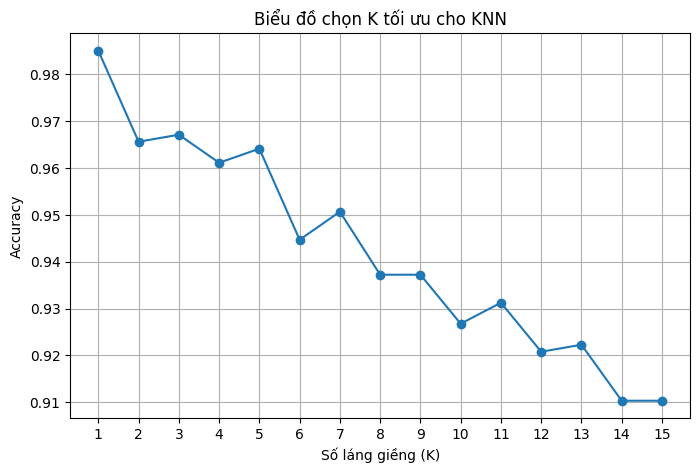

👉 K tối ưu là: 1, với Accuracy = 0.9851
🎯 Độ chính xác (Accuracy): 0.9850523168908819

📊 Báo cáo chi tiết:
               precision    recall  f1-score   support

           7       0.97      0.98      0.97        93
           8       0.98      0.99      0.99       282
           9       0.99      0.98      0.99       294

    accuracy                           0.99       669
   macro avg       0.98      0.98      0.98       669
weighted avg       0.99      0.99      0.99       669



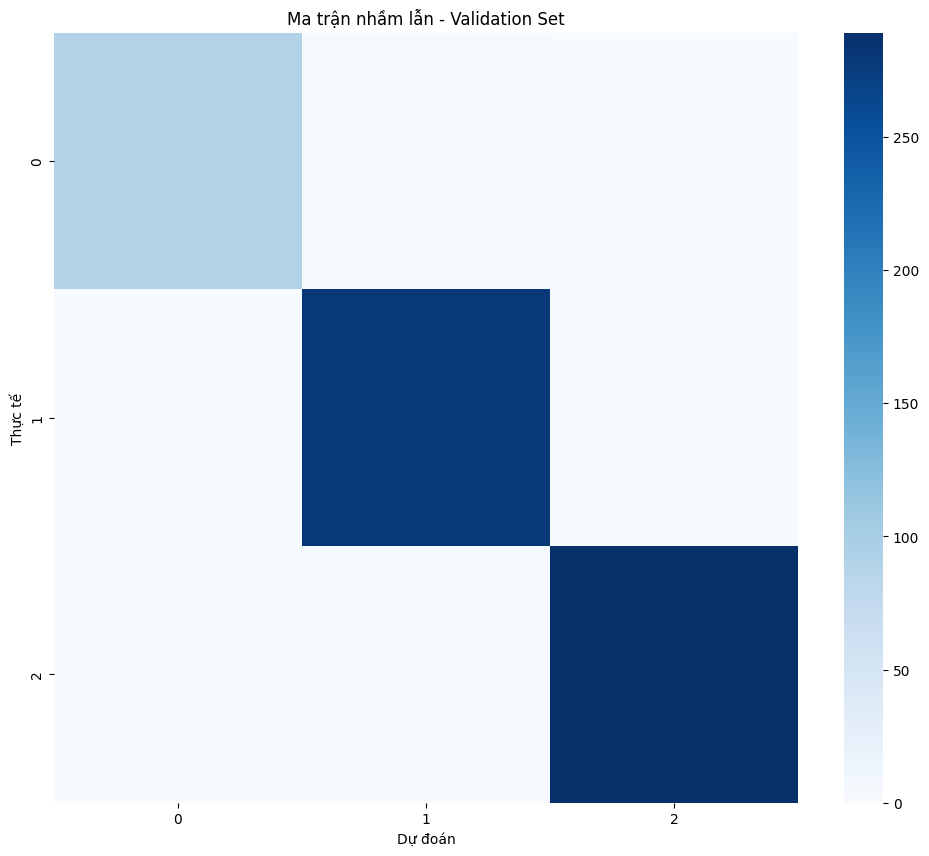

In [ ]:
# ======================
# PHẦN 3: XÂY DỰNG MÔ HÌNH KNN
# ======================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# BƯỚC 1: Làm phẳng ảnh (flatten)
# KNN không xử lý tensor 3D (48x48x3) mà cần vector 1D
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat   = X_val.reshape(len(X_val), -1)

print("Kích thước sau khi flatten:", X_train_flat.shape, X_val_flat.shape)

# ======================
# BƯỚC 2: TÌM K TỐI ƯU
# ======================
k_values = list(range(1, 16))   # Thử từ 1 đến 15 láng giềng
acc_scores = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    knn_temp.fit(X_train_flat, y_train)
    y_pred_temp = knn_temp.predict(X_val_flat)
    acc = accuracy_score(y_val, y_pred_temp)
    acc_scores.append(acc)
    print(f"K={k}, Accuracy={acc:.4f}")

# Vẽ biểu đồ Accuracy theo K
plt.figure(figsize=(8,5))
plt.plot(k_values, acc_scores, marker='o')
plt.xlabel("Số láng giềng (K)")
plt.ylabel("Accuracy")
plt.title("Biểu đồ chọn K tối ưu cho KNN")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Chọn K tốt nhất
best_k = k_values[acc_scores.index(max(acc_scores))]
print(f"👉 K tối ưu là: {best_k}, với Accuracy = {max(acc_scores):.4f}")

# ======================
# BƯỚC 3: HUẤN LUYỆN KNN VỚI K TỐI ƯU
# ======================
knn = KNeighborsClassifier(n_neighbors=best_k, metric='minkowski', p=2)
knn.fit(X_train_flat, y_train)

# ======================
# BƯỚC 4: DỰ ĐOÁN VÀ ĐÁNH GIÁ
# ======================
# KNN
y_pred_knn = knn.predict(X_val_flat)

print("🎯 Độ chính xác (Accuracy):", accuracy_score(y_val, y_pred_knn))
print("\n📊 Báo cáo chi tiết:\n", classification_report(y_val, y_pred_knn))

# Ma trận nhầm lẫn
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), cmap="Blues", annot=False, fmt="d")
plt.title("Ma trận nhầm lẫn - Validation Set")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

/tmp/ipython-input-943897542.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set2")


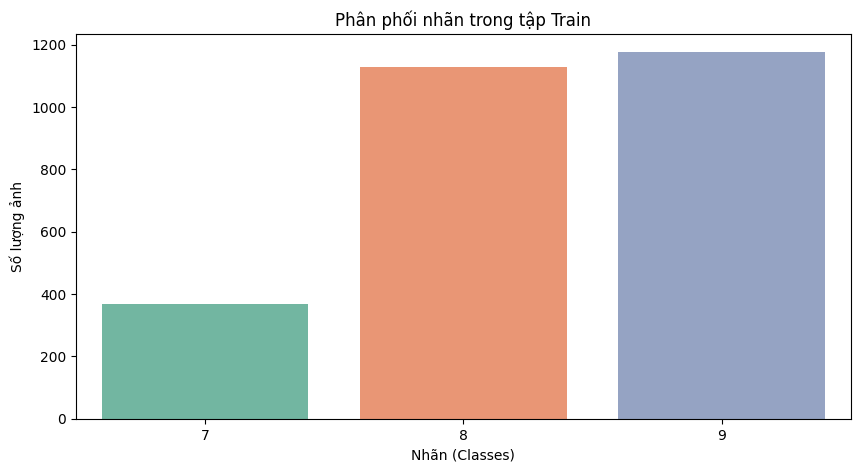

/tmp/ipython-input-943897542.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_val, palette="Set1")


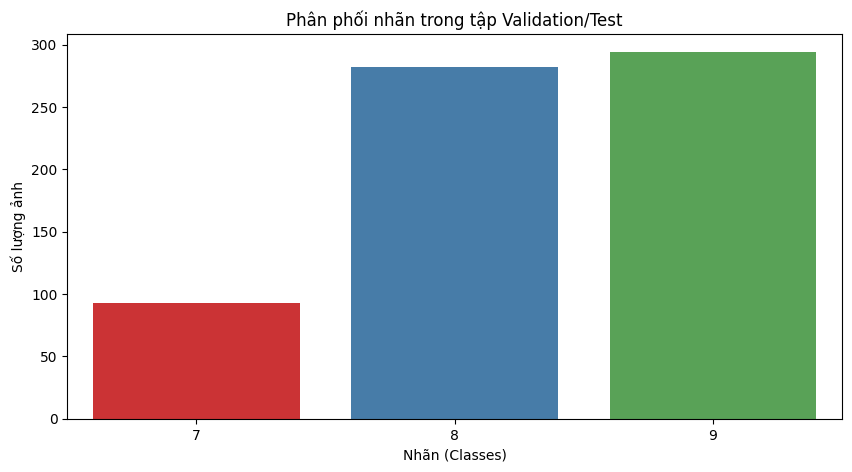

📊 Thống kê số lượng ảnh theo nhãn:
   Train  Validation
7    369          93
8   1128         282
9   1176         294


In [ ]:
# Vẽ biểu đồ phân phối cho tập Train
plt.figure(figsize=(10,5))
sns.countplot(x=y_train, palette="Set2")
plt.title("Phân phối nhãn trong tập Train")
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng ảnh")
plt.show()

# Vẽ biểu đồ phân phối cho tập Validation/Test
plt.figure(figsize=(10,5))
sns.countplot(x=y_val, palette="Set1")
plt.title("Phân phối nhãn trong tập Validation/Test")
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng ảnh")
plt.show()


# Đếm số lượng mẫu theo từng nhãn
train_counts = pd.Series(y_train).value_counts().sort_index()
val_counts   = pd.Series(y_val).value_counts().sort_index()

# Gộp vào 1 DataFrame để so sánh
label_distribution = pd.DataFrame({
    "Train": train_counts,
    "Validation": val_counts
}).fillna(0).astype(int)

print("📊 Thống kê số lượng ảnh theo nhãn:")
print(label_distribution)

Kích thước sau khi flatten: (2673, 6912) (669, 6912)
🎯 Độ chính xác (Accuracy - Naive Bayes): 0.5695067264573991

📊 Báo cáo chi tiết (Naive Bayes):
               precision    recall  f1-score   support

           7       0.18      0.11      0.13        93
           8       0.54      0.74      0.62       282
           9       0.71      0.55      0.62       294

    accuracy                           0.57       669
   macro avg       0.48      0.47      0.46       669
weighted avg       0.57      0.57      0.56       669



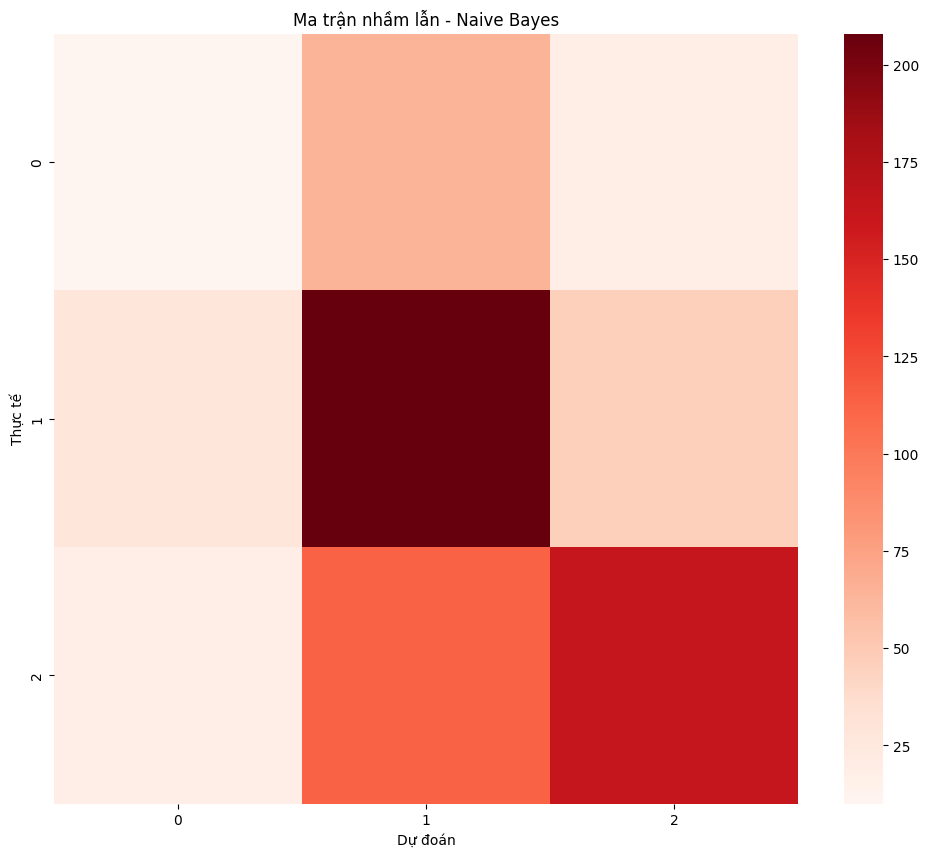

In [ ]:
# ======================
# PHẦN 3: XÂY DỰNG MÔ HÌNH NAIVE BAYES
# ======================

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ======================
# BƯỚC 1: LÀM PHẲNG ẢNH
# ======================
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat   = X_val.reshape(len(X_val), -1)

print("Kích thước sau khi flatten:", X_train_flat.shape, X_val_flat.shape)

# ======================
# BƯỚC 2: KHỞI TẠO & HUẤN LUYỆN MÔ HÌNH
# ======================
nb = GaussianNB()
nb.fit(X_train_flat, y_train)

# ======================
# BƯỚC 3: DỰ ĐOÁN
# ======================
y_pred_nb = nb.predict(X_val_flat)

# ======================
# BƯỚC 4: ĐÁNH GIÁ KẾT QUẢ
# ======================
print("🎯 Độ chính xác (Accuracy - Naive Bayes):", accuracy_score(y_val, y_pred_nb))
print("\n📊 Báo cáo chi tiết (Naive Bayes):\n", classification_report(y_val, y_pred_nb))

# Ma trận nhầm lẫn
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_val, y_pred_nb), cmap="Reds", annot=False, fmt="d")
plt.title("Ma trận nhầm lẫn - Naive Bayes")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()


Kích thước sau khi flatten: (2673, 6912) (669, 6912)
Max_depth=5, Accuracy=0.8744
Max_depth=10, Accuracy=0.9118
Max_depth=15, Accuracy=0.9163
Max_depth=20, Accuracy=0.9178
Max_depth=None, Accuracy=0.9178


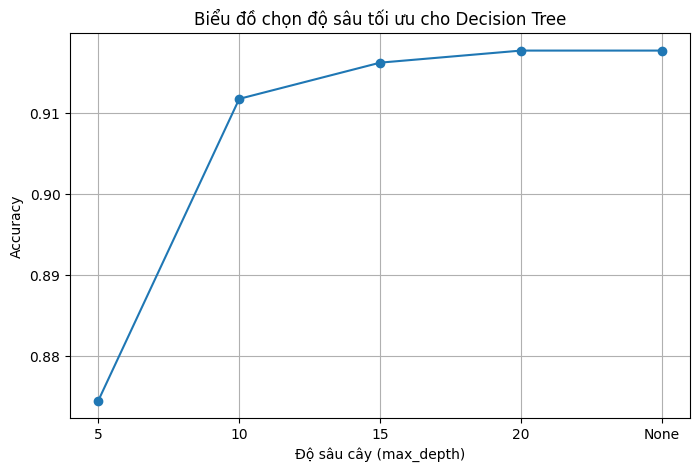

👉 Độ sâu tối ưu là: 20, với Accuracy = 0.9178
🎯 Độ chính xác (Accuracy - Decision Tree): 0.9177877428998505

📊 Báo cáo chi tiết (Decision Tree):
               precision    recall  f1-score   support

           7       0.82      0.81      0.81        93
           8       0.90      0.94      0.92       282
           9       0.96      0.94      0.95       294

    accuracy                           0.92       669
   macro avg       0.89      0.89      0.89       669
weighted avg       0.92      0.92      0.92       669



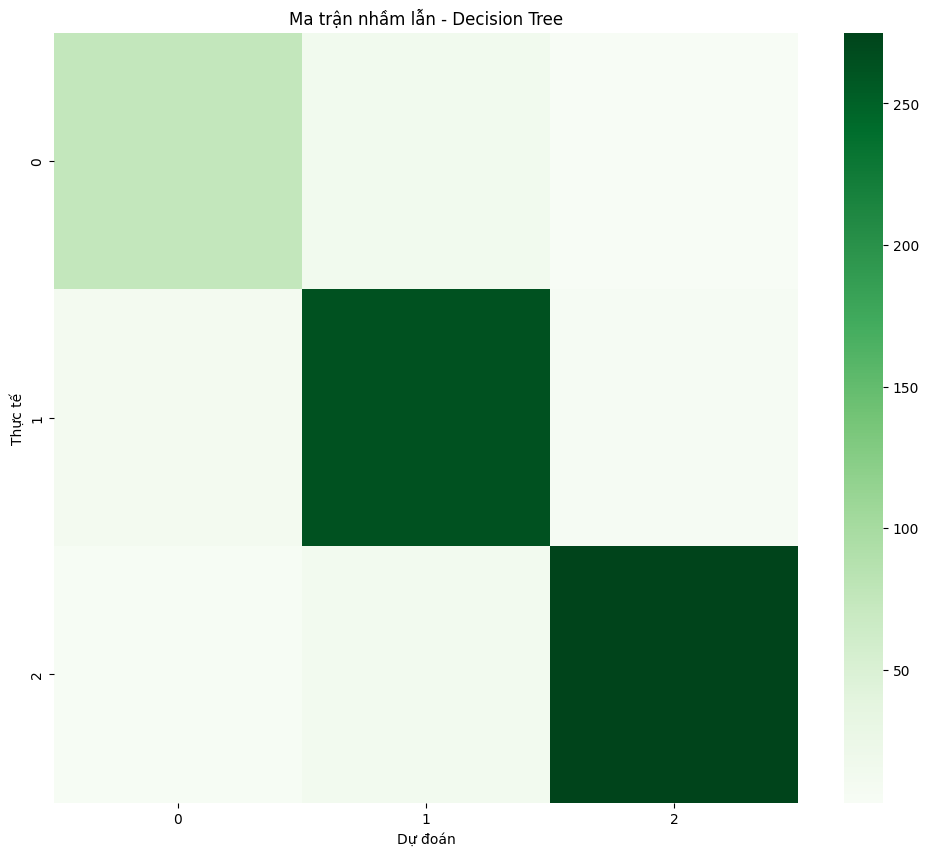

In [ ]:
# ======================
# PHẦN 4: XÂY DỰNG MÔ HÌNH DECISION TREE
# ======================

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ======================
# BƯỚC 1: LÀM PHẲNG ẢNH
# ======================
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat   = X_val.reshape(len(X_val), -1)

print("Kích thước sau khi flatten:", X_train_flat.shape, X_val_flat.shape)

# ======================
# BƯỚC 2: THỬ NGHIỆM VỚI CÁC THAM SỐ KHÁC NHAU
# ======================
depth_values = [5, 10, 15, 20, None]   # None = không giới hạn
acc_scores = []

for d in depth_values:
    dt_temp = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt_temp.fit(X_train_flat, y_train)
    y_pred_temp = dt_temp.predict(X_val_flat)
    acc = accuracy_score(y_val, y_pred_temp)
    acc_scores.append(acc)
    print(f"Max_depth={d}, Accuracy={acc:.4f}")

# Vẽ biểu đồ Accuracy theo max_depth
plt.figure(figsize=(8,5))
plt.plot([str(d) for d in depth_values], acc_scores, marker='o')
plt.xlabel("Độ sâu cây (max_depth)")
plt.ylabel("Accuracy")
plt.title("Biểu đồ chọn độ sâu tối ưu cho Decision Tree")
plt.grid(True)
plt.show()

# Chọn độ sâu tốt nhất
best_depth = depth_values[acc_scores.index(max(acc_scores))]
print(f"👉 Độ sâu tối ưu là: {best_depth}, với Accuracy = {max(acc_scores):.4f}")

# ======================
# BƯỚC 3: HUẤN LUYỆN VỚI THAM SỐ TỐI ƯU
# ======================
dt = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt.fit(X_train_flat, y_train)

# ======================
# BƯỚC 4: DỰ ĐOÁN & ĐÁNH GIÁ
# ======================
y_pred_dt = dt.predict(X_val_flat)

print("🎯 Độ chính xác (Accuracy - Decision Tree):", accuracy_score(y_val, y_pred_dt))
print("\n📊 Báo cáo chi tiết (Decision Tree):\n", classification_report(y_val, y_pred_dt))

# Ma trận nhầm lẫn
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_val, y_pred_dt), cmap="Greens", annot=False, fmt="d")
plt.title("Ma trận nhầm lẫn - Decision Tree")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()


In [1]:
# ======================
# SO SÁNH KẾT QUẢ 3 MÔ HÌNH
# ======================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gom tất cả lại để tiện xử lý
models = {
    "KNN": y_pred_knn,
    "Naive Bayes": y_pred_nb,
    "Decision Tree": y_pred_dt
}

accuracies = {}

for name, y_pred in models.items():
    acc = accuracy_score(y_val, y_pred)
    accuracies[name] = acc

    print(f"\n===== {name} =====")
    print(f"🎯 Accuracy: {acc:.4f}")
    print("📊 Classification Report:")
    print(classification_report(y_val, y_pred))

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_val, y_pred), cmap="Blues", annot=False, fmt="d")
    plt.title(f"Ma trận nhầm lẫn - {name}")
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.show()

# ======================
# Biểu đồ so sánh Accuracy
# ======================
plt.figure(figsize=(8,5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
plt.title("So sánh Accuracy giữa các mô hình")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


NameError: name 'y_pred_knn' is not defined